In [1]:
import matplotlib.pyplot as plt

from neuronunit.optimisation.optimization_management import dtc_to_rheo
import math
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
import numpy as np
attrs = {k:np.mean(v) for k,v in MODEL_PARAMS["IZHI"].items()}
from neuronunit.capabilities.spike_functions import get_spike_waveforms, spikes2widths, spikes2thresholds
from quantities import ms
from neuronunit.tests.base import AMPL, DELAY, DURATION
from neuronunit.optimisation.data_transport_container import DataTC

def spikes2thresholds_debug(spike_waveforms,axs):
    """
    IN:
     spike_waveforms: Spike waveforms, e.g. from get_spike_waveforms().
        neo.core.AnalogSignal
    OUT:
     1D numpy array of spike thresholds, specifically the membrane potential
     at which 1/10 the maximum slope is reached.

    If the derivative contains NaNs, probably because vm contains NaNs
    Return an empty list with the appropriate units

    """
    try:
        n_spikes = spike_waveforms.shape[1]
    except:
        return None
        #return thresholds * spike_waveforms.units


    thresholds = []
    if n_spikes > 1:
        # good to know can handle multispikeing
        pass
    for i in range(n_spikes):
        s = spike_waveforms[:, i].squeeze()
        #plt.plot(s.times,s.magnitude)        

        axs.plot([i for i in range(0,len(s))],s)        

        s = np.array(s)
        dvdt = np.diff(s)
        for j in dvdt:
            if math.isnan(j):
                return thresholds * spike_waveforms.units
        try:
            trigger = dvdt.max()/10.0
        except:
            return None
            # try this next.
            # return thresholds * spike_waveforms.units

        try:
            #print(np.where(dvdt >= trigger))
            x_loc = np.where(dvdt >= trigger)[0][0]
            #print(x_loc)
            thresh = (s[x_loc]+s[x_loc+1])/2
            
        except:
            thresh = None
        thresholds.append(thresh)
        axs.scatter(x_loc,thresh)
        axs.axvline(x_loc)
        
        #plt.show()
        #plt.savefig("debug_threshold.png")
        
    return axs,thresh


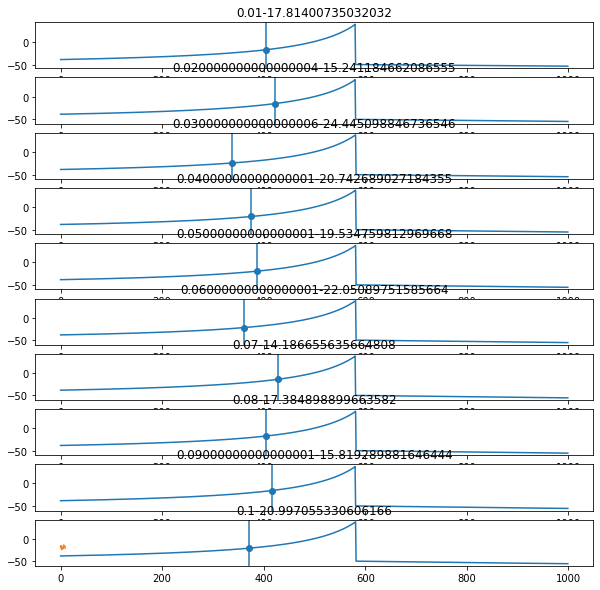

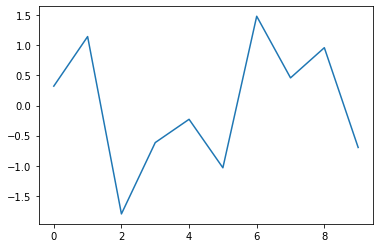

In [2]:


fig, axs = plt.subplots(10,1,figsize=(10, 10))

i = 0
thresholds = []
for slider_value in np.linspace(0.01, 0.1, 10):

  dtc = DataTC(backend="IZHI",attrs=attrs)
  dtc.attrs['a'] = slider_value
  dtc = dtc_to_rheo(dtc)
  model = dtc.dtc_to_model()
  model.attrs = model._backend.default_attrs
  model.attrs.update(dtc.attrs)
  uc = {'amplitude':dtc.rheobase,'duration':DURATION,'delay':DELAY}
  model._backend.inject_square_current(uc)
  vm = model.get_membrane_potential()
  snippets1 = get_spike_waveforms(vm)#,width=20*ms)
  axs[i],thresh = spikes2thresholds_debug(snippets1,axs[i])
  #print(thresh)
  axs[i].set_title(label = str(dtc.attrs['a'])+str(thresh))
  i +=1
  thresholds.append(thresh)

plt.plot(range(0,len(thresholds)),thresholds)
plt.show()

plt.clf()

plt.plot(range(0,len(thresholds)),[(t-np.mean(thresholds))/np.std(thresholds) for t in thresholds])
plt.show()

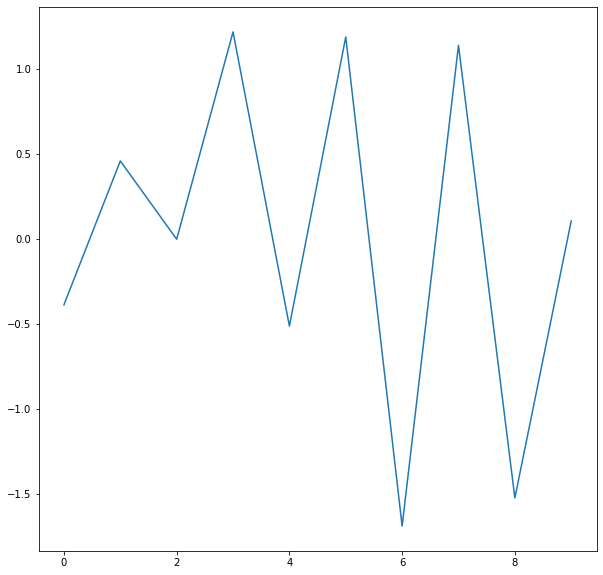

In [3]:
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
import numpy as np
attrs = {k:np.mean(v) for k,v in MODEL_PARAMS["ADEXP"].items()}
from neuronunit.capabilities.spike_functions import get_spike_waveforms, spikes2widths, spikes2thresholds
from quantities import ms
from neuronunit.tests.base import AMPL, DELAY, DURATION
from neuronunit.optimisation.data_transport_container import DataTC

fig, axs = plt.subplots(10,1,figsize=(10, 10))
i = 0
plotxvec = np.linspace(MODEL_PARAMS['ADEXP']['a'][0],MODEL_PARAMS['ADEXP']['a'][1],10)
thresholds = []
for slider_value in plotxvec:

  dtc = DataTC(backend="ADEXP",attrs=attrs)
  dtc.attrs['a'] = slider_value
  dtc = dtc_to_rheo(dtc)
  model = dtc.dtc_to_model()
  model.attrs = model._backend.default_attrs
  model.attrs.update(dtc.attrs)
  uc = {'amplitude':dtc.rheobase,'duration':DURATION,'delay':DELAY}
  model._backend.inject_square_current(uc)
  vm = model.get_membrane_potential()
  snippets1 = get_spike_waveforms(vm)#,width=20*ms)
  axs[i],thresh = spikes2thresholds_debug(snippets1,axs[i])
  axs[i].set_title(label = str(thresh))
  i +=1
  thresholds.append(thresh)
plt.clf()

plt.plot(range(0,len(thresholds)),[(t-np.mean(thresholds))/np.std(thresholds) for t in thresholds])
plt.show()

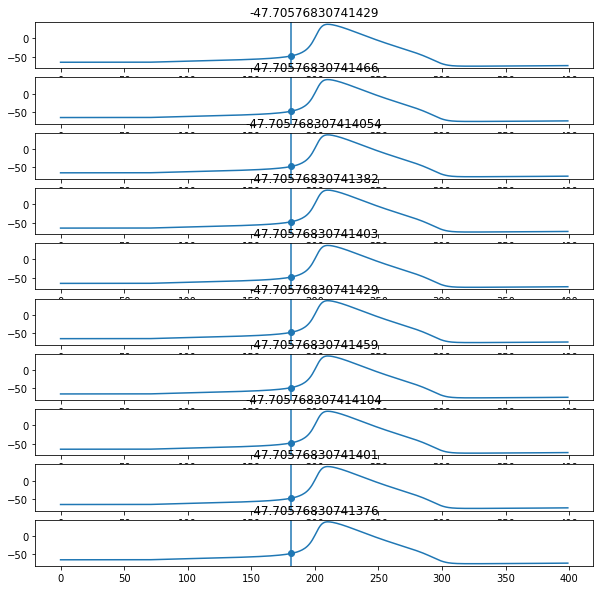

In [4]:
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
import numpy as np
attrs = {k:np.mean(v) for k,v in MODEL_PARAMS["NEURONHH"].items()}
from neuronunit.capabilities.spike_functions import get_spike_waveforms, spikes2widths, spikes2thresholds
from quantities import ms
from neuronunit.tests.base import AMPL, DELAY, DURATION
from neuronunit.optimisation.data_transport_container import DataTC

fig, axs = plt.subplots(10,1,figsize=(10, 10))
i = 0
plotxvec = np.linspace(MODEL_PARAMS['NEURONHH']['Ra'][0],MODEL_PARAMS['NEURONHH']['Ra'][1],10)
thresholds = []
for slider_value in plotxvec:

  dtc = DataTC(backend="NEURONHH",attrs=attrs)
  dtc.attrs['Ra'] = slider_value
  dtc = dtc_to_rheo(dtc)
  model = dtc.dtc_to_model()
  model.attrs = model._backend.default_attrs
  model.attrs.update(dtc.attrs)
  uc = {'amplitude':dtc.rheobase,'duration':DURATION,'delay':DELAY}
  model._backend.inject_square_current(uc)
  vm = model.get_membrane_potential()
  snippets1 = get_spike_waveforms(vm)#,width=20*ms)
  axs[i],thresh = spikes2thresholds_debug(snippets1,axs[i])
  axs[i].set_title(label = str(thresh))
  i +=1
  thresholds.append(thresh)


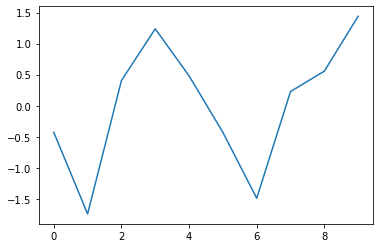

In [5]:
plt.clf()

plt.plot(range(0,len(thresholds)),[(t-np.mean(thresholds))/np.std(thresholds) for t in thresholds])
plt.show()